In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
path_train = '/drive/dataset/'

In [3]:
!pip install jsonlines pandas matplotlib nltk

In [4]:
import jsonlines
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import re
import os

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
%cd   /content/drive/MyDrive/prueba_tenica_BC/

/content/drive/MyDrive/prueba_tenica_BC


In [6]:
def load_data(dataset):
    with jsonlines.open(dataset, 'r') as reader:
        data = list(reader)
        list_messages = []
        list_labels = []
        for line in data:
            list_messages.extend(line['messages'])
            list_labels.extend(line['sender_labels'])
    dict_out = {'messages': list_messages, 'label': list_labels}
    df = pd.DataFrame(dict_out)
    return df

### Carga los dataset

In [111]:
path_test = r'./dataset/test_diplomacy.jsonl'
path_train = r'./dataset/train_diplomacy.jsonl'
path_validation = r'./dataset/validation_diplomacy.jsonl'

In [112]:
test=load_data(path_test)
train = load_data(path_train)
validation = load_data(path_validation)

### Valida los mensajes vacíos

In [113]:
na_test = test[test.isna().any(axis=1)]
na_train = train[train.isna().any(axis=1)]
na_vali = validation[validation.isna().any(axis=1)]

print("cantidad de datos vacios de entrenamiento" ,na_train.shape[0])
print("cantidad de datos vacios de validacion" ,na_vali.shape[0])
print("cantidad de datos vacios de test" ,na_test.shape[0])

cantidad de datos vacios de entrenamiento 0
cantidad de datos vacios de validacion 0
cantidad de datos vacios de test 0


### filtrar mensajes con caracteres menores a 10

In [114]:
train_raw = train[train['messages'].str.len() >= 10]
val_raw = validation[validation['messages'].str.len() >= 10]
test_raw = test[test['messages'].str.len() >= 10]

In [115]:
train_raw['label'] = (train_raw['label'] == False).astype('int')
test_raw['label'] = (test_raw['label'] == False).astype('int')
val_raw['label'] = (val_raw['label'] == False).astype('int')

train_raw = train_raw.rename(columns={'messages':'text','label':'target' })
test_raw = test_raw.rename(columns={'messages':'text','label':'target' })
val_raw=val_raw.rename(columns={'messages':'text','label':'target' })

<ipython-input-115-ec19a8b182f0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_raw['label'] = (train_raw['label'] == False).astype('int')
<ipython-input-115-ec19a8b182f0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_raw['label'] = (test_raw['label'] == False).astype('int')
<ipython-input-115-ec19a8b182f0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

In [118]:
train_false = train_raw[train_raw['target'] == 1]
train_true = train_raw[train_raw['target'] == 0]
train_true['lenght'] = train_true['text'].str.split().str.len()
train_true = train_true[(train_true['lenght'] <= 13)]
train_true.shape[0]

<ipython-input-118-f0eb8f92501f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_true['lenght'] = train_true['text'].str.split().str.len()


5617

In [119]:
train_new_true = train_true[['text','target']]
train_new_true.shape

(5617, 2)

In [120]:
train_raw = pd.concat([train_new_true, train_false], axis=0)
train_raw = train_raw.sample(frac=1).reset_index(drop=True)

In [121]:
train_raw[train_raw['target'] == 1]

,text,target
14,we don't let germany win,1
27,"Oh I just realized Germany is getting a build,...",1
29,"I think that we can pull off a great turn, but...",1
31,Nice! Get’em! He WAS moving on you. But we sho...,1
40,I would not and have not said you are plotting...,1
...,...,...
6078,Hello Turkey. We share natural enemies in Russ...,1
6083,"Alright, will you be able to provide support t...",1
6086,Perhaps you’d like support to Brest?,1
6088,"We’re friends, right? I believe that every sin...",1


In [14]:
!pip install transformers

In [31]:
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [99]:
from torch.utils.data import Dataset
import numpy as np
import re
import nltk
import string

class TweetDataset(Dataset):
    def __init__(self, dataframe, tokenizer):
        texts = dataframe.text.values.tolist()

        texts = [self._preprocess(text) for text in texts]

        self._print_random_samples(texts)

        self.texts = [tokenizer(text, padding='max_length',
                                max_length=150,
                                truncation=True,
                                return_tensors="pt")
                      for text in texts]

        if 'target' in dataframe:
            classes = dataframe.target.values.tolist()
            self.labels = classes

    def _print_random_samples(self, texts):
        np.random.seed(42)
        random_entries = np.random.randint(0, len(texts), 5)

        for i in random_entries:
            print(f"Entry {i}: {texts[i]}")

        print()

    def _preprocess(self, text):
        text = self._remove_multiple_spaces(text)

        #text = self._lowercase(text)
        text = self._remove_punctuation(text)
        #text = self._remove_numbers(text)

        text_tokens = self._tokenize(text)
        text_tokens = self._stopword_filtering(text_tokens)
        #text_tokens = self._stemming(text_tokens)
        text = self._stitch_text_tokens_together(text_tokens)

        return text.strip()


    def _remove_amp(self, text):
        return text.replace("&amp;", " ")

    def _remove_mentions(self, text):
        return re.sub(r'(@.*?)[\s]', ' ', text)

    def _remove_multiple_spaces(self, text):
        return re.sub(r'\s+', ' ', text)

    def _remove_retweets(self, text):
        return re.sub(r'^RT[\s]+', ' ', text)

    def _remove_links(self, text):
        return re.sub(r'https?:\/\/[^\s\n\r]+', ' ', text)

    def _remove_hashes(self, text):
        return re.sub(r'#', ' ', text)

    def _stitch_text_tokens_together(self, text_tokens):
        return " ".join(text_tokens)

    def _tokenize(self, text):
        return nltk.word_tokenize(text, language="english")

    def _stopword_filtering(self, text_tokens):
        stop_words = nltk.corpus.stopwords.words('english')

        return [token for token in text_tokens if token not in stop_words]

    def _stemming(self, text_tokens):
        porter = nltk.stem.porter.PorterStemmer()
        return [porter.stem(token) for token in text_tokens]

    def _remove_numbers(self, text):
        return re.sub(r'\d+', ' ', text)

    def _lowercase(self, text):
        return text.lower()

    def _remove_punctuation(self, text):
        return ''.join(character for character in text if character not in string.punctuation)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]

        label = -1
        if hasattr(self, 'labels'):
            label = self.labels[idx]

        return text, label

### Contruyendo el clasificador

In [100]:
from torch import nn

class TweetClassifier(nn.Module):
    def __init__(self, base_model):
        super(TweetClassifier, self).__init__()

        self.bert = base_model
        self.fc1 = nn.Linear(768, 32)
        self.fc2 = nn.Linear(32, 1)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        bert_out = self.bert(input_ids=input_ids,
                             attention_mask=attention_mask)[0][:, 0]
        x = self.fc1(bert_out)
        x = self.relu(x)

        x = self.fc2(x)
        x = self.sigmoid(x)

        return x

In [128]:
import torch
from torch.optim import Adam, AdamW
from tqdm import tqdm

def train(model, train_dataloader, val_dataloader, learning_rate, epochs):
    best_val_loss = float('inf')
    early_stopping_threshold_count = 0


    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    #loss_function = torch.nn.BCELoss(weight=weights)
    weights = torch.tensor([8.0])
    criterion = nn.BCELoss(weight=None)
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    model = model.to(device)
    criterion = criterion.to(device)

    for epoch in range(epochs):
        total_acc_train = 0
        total_loss_train = 0

        model.train()

        for train_input, train_label in tqdm(train_dataloader):
            attention_mask = train_input['attention_mask'].to(device)
            input_ids = train_input['input_ids'].squeeze(1).to(device)

            train_label = train_label.to(device)

            output = model(input_ids, attention_mask)

            loss = criterion(output, train_label.float().unsqueeze(1))

            total_loss_train += loss.item()

            acc = ((output >= 0.5).int() == train_label.unsqueeze(1)).sum().item()
            total_acc_train += acc

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        with torch.no_grad():
            total_acc_val = 0
            total_loss_val = 0

            model.eval()

            for val_input, val_label in tqdm(val_dataloader):
                attention_mask = val_input['attention_mask'].to(device)
                input_ids = val_input['input_ids'].squeeze(1).to(device)

                val_label = val_label.to(device)

                output = model(input_ids, attention_mask)

                loss = criterion(output, val_label.float().unsqueeze(1))

                total_loss_val += loss.item()

                acc = ((output >= 0.5).int() == val_label.unsqueeze(1)).sum().item()
                total_acc_val += acc

            print(f'Epochs: {epoch + 1} '
                  f'| Train Loss: {total_loss_train / len(train_dataloader): .3f} '
                  f'| Train Accuracy: {total_acc_train / (len(train_dataloader.dataset)): .3f} '
                  f'| Val Loss: {total_loss_val / len(val_dataloader): .3f} '
                  f'| Val Accuracy: {total_acc_val / len(val_dataloader.dataset): .3f}')

            if best_val_loss > total_loss_val:
                best_val_loss = total_loss_val
                torch.save(model, f"best_model_10.pt")
                print("Saved model")
                early_stopping_threshold_count = 0
            else:
                early_stopping_threshold_count += 1

            if early_stopping_threshold_count >= 1:
                print("Early stopping")
                continue

In [129]:
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import DataLoader

torch.manual_seed(0)
np.random.seed(0)


BERT_MODEL = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL)
base_model = AutoModel.from_pretrained(BERT_MODEL)

train_dataloader = DataLoader(TweetDataset(train_raw, tokenizer), batch_size=8, shuffle=True, num_workers=0)
val_dataloader = DataLoader(TweetDataset(val_raw, tokenizer), batch_size=8, num_workers=0)

model = TweetClassifier(base_model)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Entry 860: Alright What plans North Sea days
Entry 5390: What us stuff would like discuss
Entry 5226: Where work
Entry 5191: That ’ fair It ’ also make sense mess around Greece build army focus navy If structure build types well keep relationship fairly balanced I think I might able sneak Italian gains early considering moving direction Russia stays Gal 1901 If works ’ worry Lepanto
Entry 3772: Turkey may take lot

Entry 1126: I gon na self bounce Rumania
Entry 860: Ok supporting Burgundy Up
Entry 1294: Id prefer make go Austria first Ill crank fleets deal Italy
Entry 1130: Okay ’ good
Entry 1095: It ’ moving



In [130]:
learning_rate = 1e-5
epochs = 5
train(model, train_dataloader, val_dataloader, learning_rate, epochs)

100%|██████████| 171/171 [00:10<00:00, 15.55it/s]


Epochs: 1 | Train Loss:  0.213 | Train Accuracy:  0.938 | Val Loss:  0.955 | Val Accuracy:  0.696
Saved model


100%|██████████| 171/171 [00:11<00:00, 15.31it/s]


Epochs: 2 | Train Loss:  0.169 | Train Accuracy:  0.956 | Val Loss:  1.566 | Val Accuracy:  0.590
Early stopping


100%|██████████| 171/171 [00:11<00:00, 15.26it/s]


Epochs: 3 | Train Loss:  0.158 | Train Accuracy:  0.958 | Val Loss:  1.411 | Val Accuracy:  0.646
Early stopping


100%|██████████| 171/171 [00:11<00:00, 15.26it/s]


Epochs: 4 | Train Loss:  0.144 | Train Accuracy:  0.962 | Val Loss:  1.403 | Val Accuracy:  0.649
Early stopping


100%|██████████| 171/171 [00:11<00:00, 15.26it/s]

Epochs: 5 | Train Loss:  0.136 | Train Accuracy:  0.965 | Val Loss:  1.612 | Val Accuracy:  0.654
Early stopping


In [89]:
!pip install torcheval

In [58]:
from torcheval.metrics.functional import binary_f1_score
#from torchmetrics.classification import BinaryF1Score

In [108]:
def get_text_predictions(model, loader):
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    y_pred = []
    y_true = []
    model = model.to(device)


    results_predictions = []
    with torch.no_grad():
        model.eval()
        for data_input, labels in tqdm(loader):
            labels = labels.type(torch.LongTensor)
            labels = labels.to(device)
            attention_mask = data_input['attention_mask'].to(device)
            input_ids = data_input['input_ids'].squeeze(1).to(device)


            output = model(input_ids, attention_mask)
            from torcheval.metrics.functional import binary_f1_score
            #print(output)
            output = (output > 0.5).int()
            y_pred.extend(output.tolist())
            y_true.extend(labels.tolist())
            #results_predictions.append(output)
    from sklearn.metrics import f1_score, confusion_matrix,\
    classification_report
    f1_score_res = f1_score(y_true,y_pred)

    print(classification_report(y_true, y_pred, labels=[0,1], digits=4))
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")
    #return torch.cat(results_predictions).cpu().detach().numpy()
    return f1_score_res, y_pred

In [131]:
#model = torch.load("best_model.pt")

test_dataloader = DataLoader(TweetDataset(test_raw, tokenizer),
	batch_size=8, shuffle=False, num_workers=0)

Entry 860: So looks like worked something Russia carve Germany ’ reorienting You want coordinate anything I “ enemy ” 🙂
Entry 1294: I inclined agree How would like approach Scandinavia
Entry 1130: whats
Entry 1095: And reason trust HolBel would mean lose one two since Russia MunRuh cut Ruh S Hol counterattacked Bur RuhMun could possibly take Munich
Entry 1638: Thoughts moves



100%|██████████| 322/322 [00:20<00:00, 15.55it/s]


              precision    recall  f1-score   support

           0     0.9435    0.6207    0.7488      2341
           1     0.1429    0.6298    0.2329       235

    accuracy                         0.6215      2576
   macro avg     0.5432    0.6252    0.4908      2576
weighted avg     0.8705    0.6215    0.7017      2576

f1_score: 0.23288749016522423


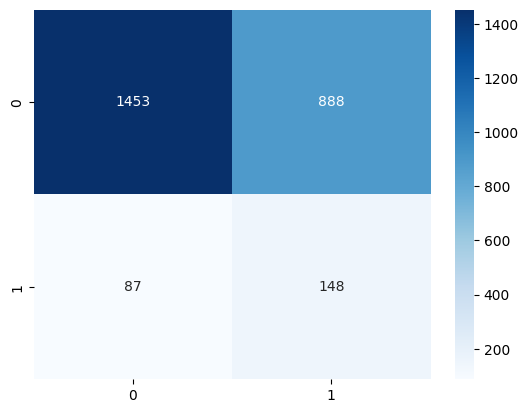

In [132]:
f1_score, y_true = get_text_predictions(model, test_dataloader)
print(f'f1_score: {f1_score}')